In [ ]:
import pandas as pd
import os 
import subprocess
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile, InterProScanFile
from src import get_genome_id
from src import fillna
from src.dataset import Dataset
from utils import * 
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import subprocess
from scipy.stats import pearsonr

%load_ext autoreload 
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}
# TODO: Definitely want to look at model confidence on the sequences.
# TODO: Exactly how many spurious genes per genome should I expect? 
# TODO: Why would balancing batches with up-sampling do so much better than weighted loss?
# TODO: Remind myself about difference between Pearson's R and Spearman's Rho, and the assumptions made for each. 
# TODO: Was the model successful at flagging unlabeled pseudogenes with InterProScan hits (the ones I didn't bother manually-labeling) as real?
# TODO: Look into why ORF prediction is worse in high-GC genomes. https://pubmed.ncbi.nlm.nih.gov/23000023/ 

In [4]:
# Based on the table_1 results, it seems as though the v2 model (two layers) made the fewest predictions... that means I think it might be the safest.
model_name = 'campylobacterota_esm_650m_gap_v2'

test_genome_ids = pd.read_csv('../data/campylobacterota_dataset_test.csv', index_col=0).genome_id.unique()
genome_ids = pd.read_csv('../data/campylobacterota_dataset.csv', index_col=0).genome_id.unique()

results = Results(genome_ids, load_ref=True, load_labels=True)
results.load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=model_name)

test_results = Results(test_genome_ids, load_ref=True, load_labels=True)
test_results.load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name=model_name)

In [ ]:
results.to_fasta(f'../data/{model_name}_spurious.faa', model_label=0)

In [ ]:
def table_1(model_names:list=['campylobacterota_esm_650m_gap_v1', 'campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v3']):
    results = Results(genome_ids=genome_ids, load_labels=True, load_ref=True)
    results.load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=None)
    df = results.to_df()
    
    table_df = []
    for model_name in model_names:
        df_ = df.groupby('category')[f'{model_name}_label'].value_counts().reset_index()
        df_ = df_.pivot(columns=f'{model_name}_label', values='count', index='category')
        df_.columns = pd.MultiIndex.from_tuples([(model_name, 'spurious'), (model_name, 'real')])
        table_df.append(df_)
    table_df = pd.concat(table_df, axis=1)
    return table_df 

table_1() 


campylobacterota_esm_650m_gap_v1          \
                                   spurious    real   
category                                              
conflict                                408     257   
intergenic                              167    3922   
match                                    73  361909   
none                                    229   42304   

           campylobacterota_esm_650m_gap_v2          \
                                   spurious    real   
category                                              
conflict                                383     282   
intergenic                              101    3988   
match                                    35  361947   
none                                    147   42386   

           campylobacterota_esm_650m_gap_v3          
                                   spurious    real  
category                                             
conflict                                400     265  
intergenic                              141    3948  
match                                    60  361922  
none                                    198   42335

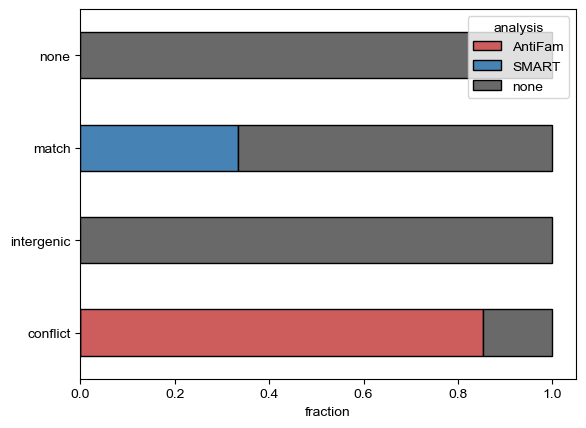

In [ ]:
def figure_1(pred_df:pd.DataFrame, normalize:bool=True, threshold:float=0.95):
    interpro_df = InterProScanFile(f'../data/{model_name}_spurious_interpro.tsv').to_df(drop_duplicates=True, max_e_value=1e-5).drop(columns=['length', 'stop', 'start'])

    fig = plt.figure()
    ax = fig.add_subplot()

    pred_df = pred_df[pred_df.model_output_0 > threshold]

    ax_df = pred_df[['model_label', 'category', 'label']].copy()
    ax_df = fillna(ax_df.merge(interpro_df, left_index=True, right_index=True, how='left'), rules={str:'none'}, errors='ignore')
    ax_df = ax_df[ax_df.model_label == 0]
    ax_df['analysis'] = ax_df.analysis.replace({'Gene3D':'other', 'SUPERFAMILY':'other', 'PANTHER':'other'})
    ax_df = ax_df.groupby('category').analysis.value_counts().reset_index()
    ax_df = ax_df.pivot(index='category', columns='analysis', values='count').fillna(0)
    # ax_df = ax_df.loc[:, ['none', 'other', 'AntiFam', 'Pfam', 'SMART']]
    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)
    # print(ax_df.columns)
    colors = {'none':'dimgray', 'Pfam':'darkseagreen', 'AntiFam':'indianred', 'MobiDBLite':'steelblue', 'SMART':'steelblue', 'other':'lightgray'}
    ax_df.plot(kind='barh', stacked=True, ax=ax, edgecolor='black', color=colors) # color=['indianred', 'darkseagreen', 'lightsteelblue', 'steelblue', 'dimgray', 'lightgray'])
    ax.set_ylabel('')
    ax.set_xlabel('count' if (not normalize) else 'fraction')
    plt.show()

figure_1(predictions['all'])

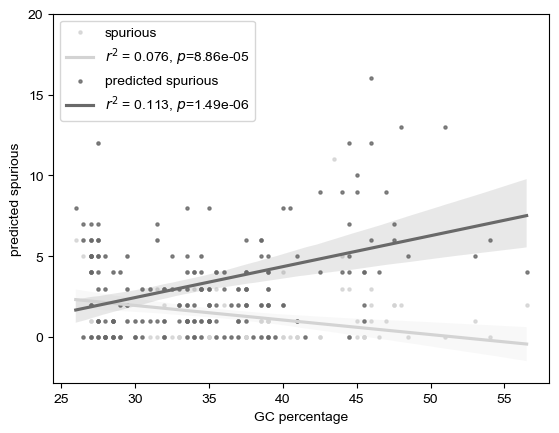

In [ ]:
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-119
def figure_1(pred_df:pd.DataFrame, genome_metadata_df:pd.DataFrame, threshold:float=0.5):
    
    pred_df = pred_df[pred_df.model_output_0 > threshold]

    fig = plt.figure()
    ax = fig.add_subplot()

    ax_df = pred_df[['in_train_dataset', 'genome_id']].groupby('genome_id').first()
    ax_df['spurious'] = pred_df.groupby('genome_id').apply(lambda df : (df.label == 'spurious').sum(), include_groups=False)
    ax_df['predicted spurious'] = pred_df.groupby('genome_id').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['difference'] = ax_df['predicted spurious'] - ax_df['spurious']
    ax_df = ax_df.merge(genome_metadata_df[['gc_percent', 'n_gene_protein_coding']], right_index=True, left_index=True, how='left')
    ax_df = ax_df.reset_index()

    ax = sns.regplot(data=ax_df, x='gc_percent', y='spurious', color='lightgray', ax=ax, label='spurious', scatter_kws={'s':5})
    ax = sns.regplot(data=ax_df, x='gc_percent', y='predicted spurious', color='dimgray', ax=ax, label='predicted spurious', scatter_kws={'s':5})
    ax.set_xlabel('GC percentage')
    
    legend_labels = list()
    for category, line in zip(['spurious', 'predicted spurious'], ax.lines):
        r, p = pearsonr(ax_df['gc_percent'], ax_df[category])
        line.set_label(f'$r^2$ = {r**2:.3f}, $p$={p:.2e}')

    ax.legend()
    ax.set_ylim(ymax=20)

    plt.show()

figure_1(predictions['all'], genome_metadata_df)

# I think there should be more like ~50-100 spurious predictions per genome. 



In [5]:
is_spurious = lambda df : df.label == 'spurious'

is_intergenic = lambda df : ~is_spurious(df) & (df.category == 'intergenic')
is_match = lambda df : ~is_spurious(df) & (df.category == 'match')
is_conflict = lambda df : ~is_spurious(df) & (df.category == 'conflict')
is_none = lambda df : ~is_spurious(df) & (df.category == 'none') # These are the suspect sequences. 

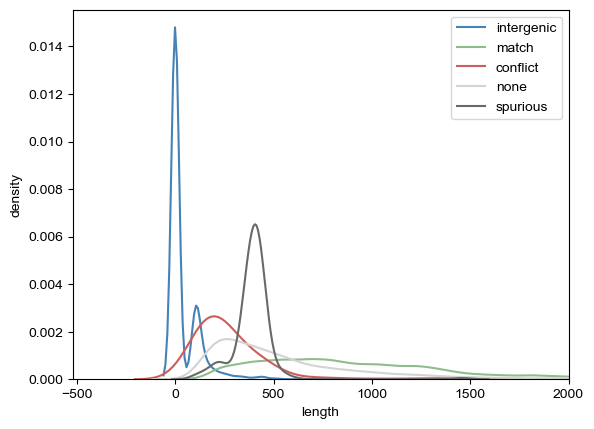

In [222]:
def figure_1(pred_df:pd.DataFrame, max_length:int=2000, threshold:float=0.95):
    # pred_df = pred_df[pred_df.model_label == 0].copy()
    pred_df = pred_df[pred_df.model_output_0 > threshold]

    fig = plt.figure()
    ax = fig.add_subplot()

    colors = ['steelblue', 'darkseagreen', 'indianred', 'lightgray', 'dimgray']
    categories = ['intergenic', 'match', 'conflict', 'none', 'spurious']
    masks = [is_intergenic(pred_df), is_match(pred_df), is_conflict(pred_df), is_none(pred_df), is_spurious(pred_df)]
    ax_df = pred_df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[['category', 'query_length']]
    ax_df = ax_df.rename(columns={'query_length':'length'})

    for category, color in zip(categories, colors):
        sns.kdeplot(data=ax_df[ax_df.category == category], x='length', ax=ax, linewidth=1.5, color=color, label=category, common_norm=False)
    ax.legend()
    ax.set_xlim(xmax=2000)
    ax.set_ylabel('density')
    plt.show()

figure_1(predictions['all'], threshold=0)

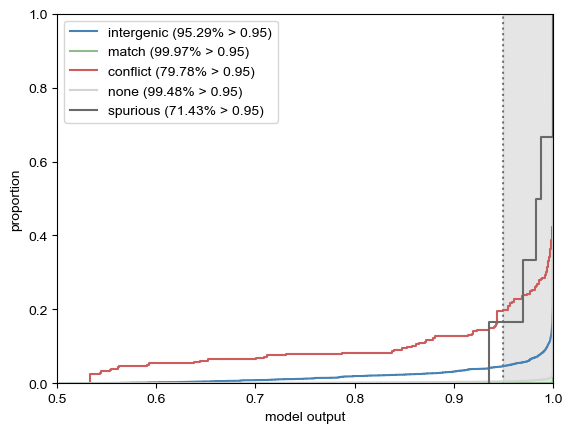

In [13]:
def figure_4(pred_df:pd.DataFrame, threshold:float=0.95, model_label:int=1):

    pred_df = pred_df[pred_df.model_label == model_label]
    
    fig = plt.figure()
    ax = fig.add_subplot(xlim=(0.5, 1))

    categories = ['intergenic', 'match', 'conflict', 'none', 'spurious']
    colors = ['steelblue', 'darkseagreen', 'indianred', 'lightgray', 'dimgray']
    masks = [is_intergenic(pred_df), is_match(pred_df), is_conflict(pred_df), is_none(pred_df), is_spurious(pred_df)]
    ax_df = pred_df[[f'model_output_{model_label}']].copy()
    ax_df['length'] = pred_df.query_length // 3
    ax_df['category'] = np.select(masks, categories, default=None)

    # sns.stripplot(data=ax_df, jitter=True, x='category', y='model_output_0', hue='category', palette=colors, hue_order=categories)
    for category, color in zip(categories, colors): # Plot each independently so the lines have labels. 
        sns.ecdfplot(data=ax_df[ax_df.category == category], x=f'model_output_{model_label}', color=color, label=category, ax=ax)
    
    legend_labels = []
    for line in ax.lines:
        x, _ = line.get_xydata().T
        p = ((x > threshold).sum() / len(x)) * 100
        p = f'({p:.2f}% > {threshold})'
        n = f'({(x > threshold).sum()} > {threshold})'
        legend_labels.append(f'{line.get_label()} {p}')

    ax.legend(labels=legend_labels)
    ax.set_ylabel('proportion')
    ax.set_xlabel('model output')
    ax.vlines([threshold], ymin=0, ymax=1, linestyle=':', color='black', zorder=-1, alpha=0.5)
    ax.fill_between((threshold, 1), 1, color='black', alpha=0.1, zorder=-1)

    plt.show()

    return ax 

ax = figure_4(predictions['all'])

In [202]:
def table_1(path:str=None):

    model_names = ['campylobacterota_esm_650m_gap_v1', 'campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v3']
    pred_df = load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name=None).drop(columns=['label', 'seq', 'genome_id'])
    pred_df = pred_df.merge(pd.read_csv('../data/campylobacterota_dataset_test.csv', dtype=dtypes, index_col=0), left_index=True, right_index=True, how='left')
    table_df = list()
    for model_name in model_names:
        row = dict()
        row['feature type'] = re.search('(esm_650m_gap|pt5_3b_gap|esm_3b_gap)', model_name).group(1) 
        row['model_name'] = model_name
        row.update(pred_df[f'{model_name}_confusion_matrix'].replace(confusion_matrix_map).value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(pred_df.label, pred_df[f'{model_name}_label']), 4)
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false positive')
    return table_df

table_1()


,feature type,true positive,true negative,false negative,false positive,accuracy
model_name,,,,,,
campylobacterota_esm_650m_gap_v1,esm_650m_gap,12550,56,6,1,0.9910
campylobacterota_esm_650m_gap_v2,esm_650m_gap,12554,56,2,1,0.9911
campylobacterota_esm_650m_gap_v3,esm_650m_gap,12550,55,6,2,0.9822
